###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [1]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [2]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [3]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [4]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
614,Egypt,2023,3.881,9.480,0.730,64.00,0.625,-0.210,NaN,0.436,0.352
201,Benin,2017,4.853,7.984,0.436,54.90,0.727,-0.068,0.767,0.598,0.458
1994,Sweden,2013,7.434,10.789,0.916,71.32,0.936,0.154,0.324,0.782,0.184
645,Estonia,2019,6.035,10.496,0.934,69.20,0.887,-0.101,0.576,0.738,0.156
1268,Malawi,2013,4.035,7.246,0.563,52.78,0.752,0.049,0.857,0.699,0.248


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [5]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [6]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [7]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [8]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [9]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\Sohin\AppData\Local\Temp\ipykernel_52268\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


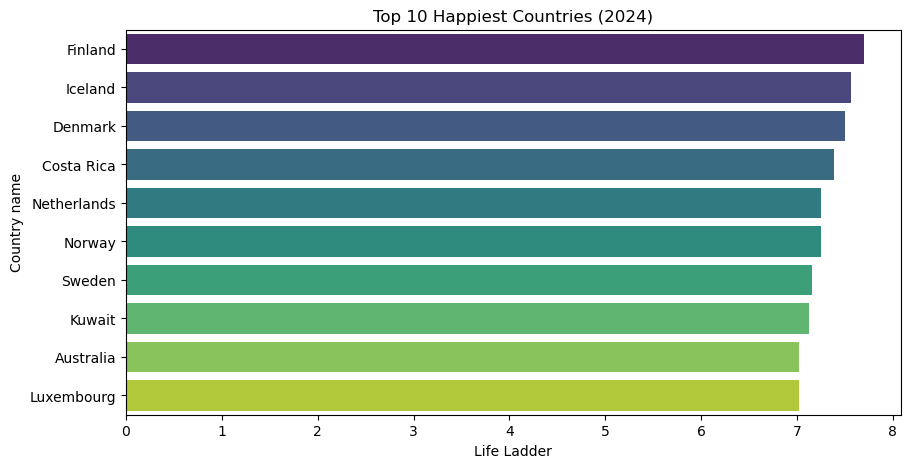

C:\Users\Sohin\AppData\Local\Temp\ipykernel_52268\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


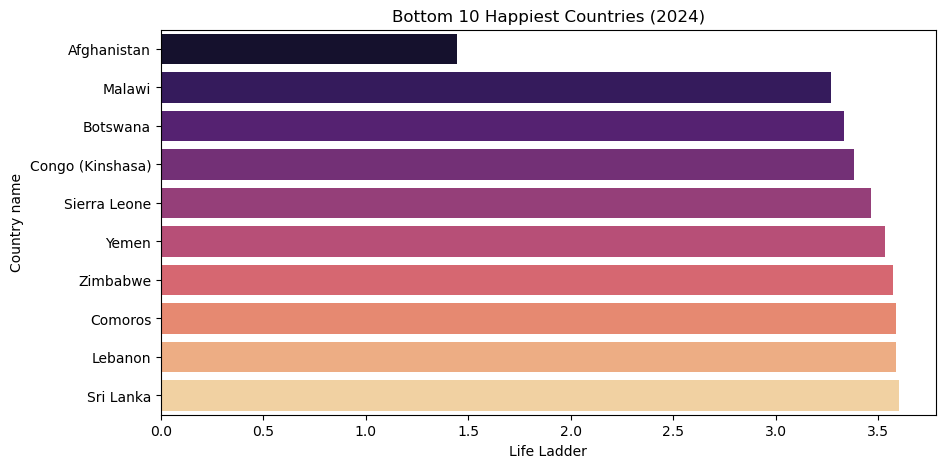

In [10]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


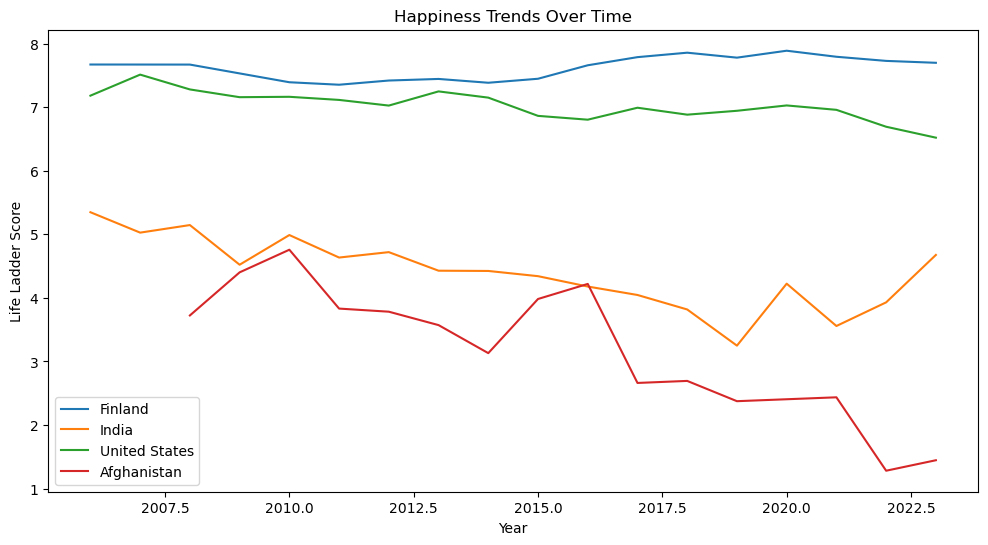

In [11]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


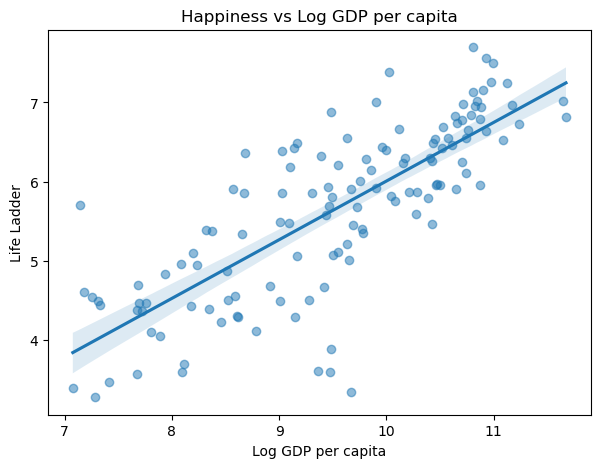

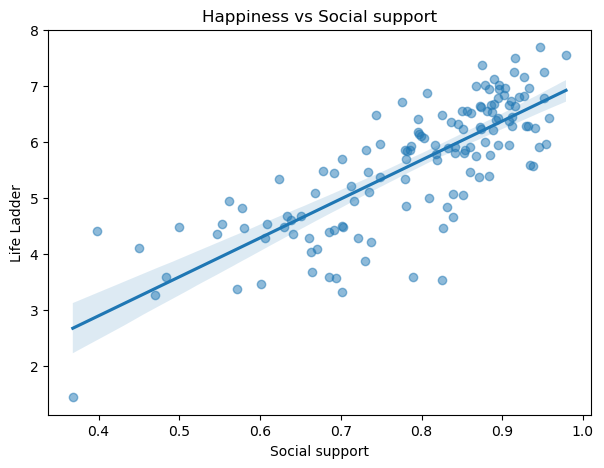

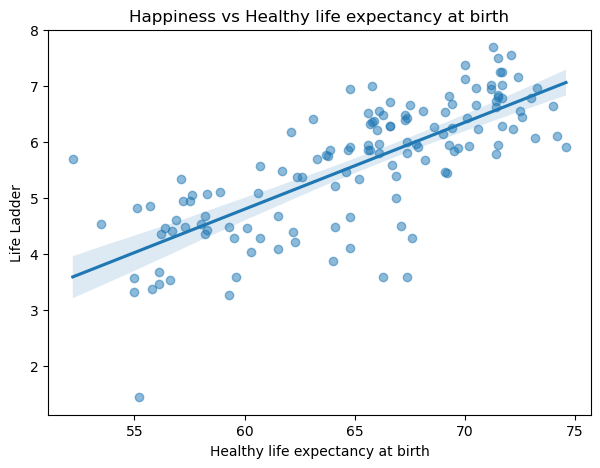

In [12]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


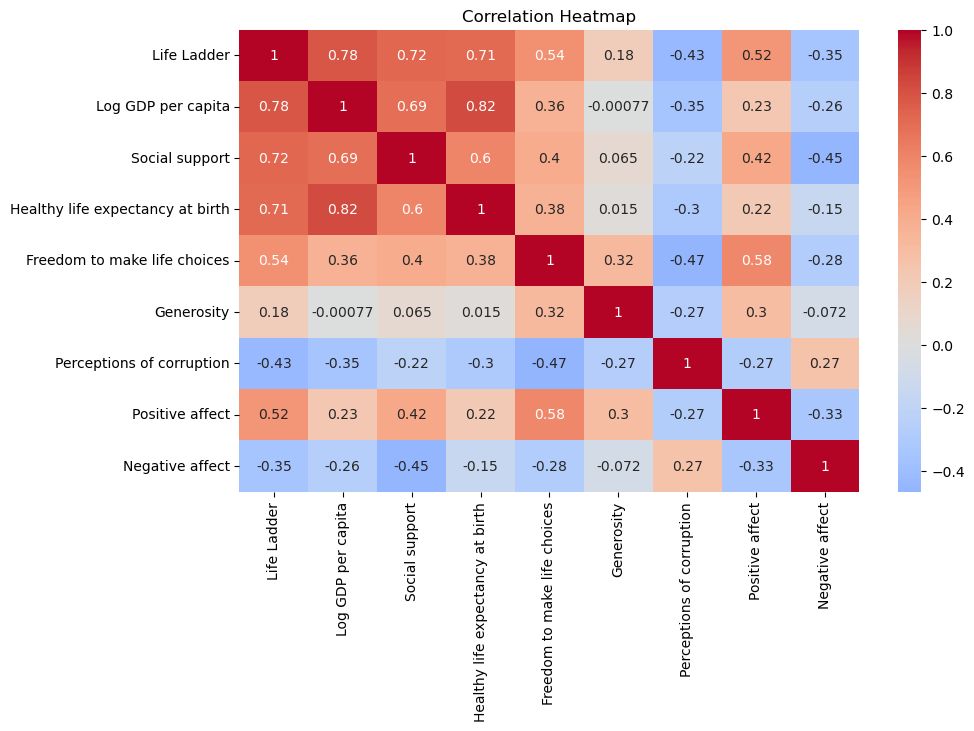

In [13]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


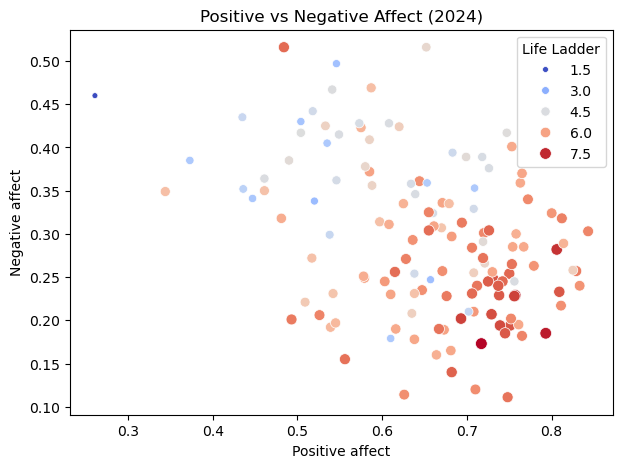

In [14]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [16]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [17]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [18]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [19]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [20]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [21]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [22]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [23]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [24]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [25]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [26]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

In [27]:
# scaler = StandardScaler()
# scaler.fit(features_train)
# features_train = scaler.transform(features_train)
# features_test = scaler.transform(features_test)

In [28]:
# # For neural networks specifically, standardizing the target is often also a good idea--we can inverse transform to compare to other models
# target_scaler = StandardScaler()
# target_scaler.fit(target_train.values.reshape(-1,1))
# target_train_scaled = target_scaler.transform(target_train.values.reshape(-1,1)).flatten()
# target_test_scaled = target_scaler.transform(target_test.values.reshape(-1,1)).flatten()

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [29]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [30]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 12:12:35,396] A new study created in memory with name: no-name-0cb2cb34-4b8b-482d-b0d9-c4435ed6fdfa
[I 2025-09-30 12:12:37,119] Trial 0 finished with value: 0.3395779340229337 and parameters: {'n_estimators': 130, 'max_depth': 12}. Best is trial 0 with value: 0.3395779340229337.
[I 2025-09-30 12:12:37,238] Trial 1 finished with value: 0.34896091470264257 and parameters: {'n_estimators': 40, 'max_depth': 9}. Best is trial 0 with value: 0.3395779340229337.
[I 2025-09-30 12:12:37,283] Trial 2 finished with value: 0.43858062439116224 and parameters: {'n_estimators': 120, 'max_depth': 3}. Best is trial 0 with value: 0.3395779340229337.
[I 2025-09-30 12:12:38,363] Trial 3 finished with value: 0.3375275899607038 and parameters: {'n_estimators': 140, 'max_depth': 11}. Best is trial 3 with value: 0.3375275899607038.
[I 2025-09-30 12:12:38,556] Trial 4 finished with value: 0.3586808404619732 and parameters: {'n_estimators': 70, 'max_depth': 8}. Best is trial 3 with value: 0.3375275

In [31]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 160, 'max_depth': 15}
At trial:  19
Mean absolute error:  0.3313335351906126

Hyperparameter importances:


{'max_depth': 0.8178486984633497, 'n_estimators': 0.18215130153665027}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [32]:
from sklearn.ensemble import RandomForestRegressor

rtf = RandomForestRegressor()
rtf.fit(features_train, target_train)
rtf_pred = rtf.predict(features_test)
rtf_mae = mean_absolute_error(target_test, rtf_pred)
rtf_mae


0.33779513888888885

In [33]:
from sklearn.tree import DecisionTreeRegressor

dtr= DecisionTreeRegressor()
dtr.fit(features_train, target_train)
dtr_pred = rtf.predict(features_test)
dtr_mae = mean_absolute_error(target_test, dtr_pred)
dtr_mae


0.33779513888888885

In [34]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor()
lgbm.fit(features_train, target_train)
lgbm_pred = lgbm.predict(features_test)
lgbm_mae = mean_absolute_error(target_test, lgbm_pred)
lgbm_mae

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

0.32155635237480695

In [35]:
from catboost import CatBoostRegressor

cbr = CatBoostRegressor()
cbr.fit(features_train, target_train)
cbr_pred = cbr.predict(features_test)
cbr_mae = mean_absolute_error(target_test, cbr_pred)
cbr_mae

Learning rate set to 0.044626
0:	learn: 1.0948076	total: 154ms	remaining: 2m 33s
1:	learn: 1.0603695	total: 160ms	remaining: 1m 19s
2:	learn: 1.0276068	total: 166ms	remaining: 55.2s
3:	learn: 0.9969302	total: 172ms	remaining: 42.8s
4:	learn: 0.9677158	total: 178ms	remaining: 35.4s
5:	learn: 0.9407344	total: 183ms	remaining: 30.3s
6:	learn: 0.9142003	total: 186ms	remaining: 26.4s
7:	learn: 0.8899628	total: 189ms	remaining: 23.4s
8:	learn: 0.8662062	total: 193ms	remaining: 21.2s
9:	learn: 0.8423363	total: 196ms	remaining: 19.4s
10:	learn: 0.8198180	total: 198ms	remaining: 17.8s
11:	learn: 0.8005310	total: 202ms	remaining: 16.7s
12:	learn: 0.7803021	total: 207ms	remaining: 15.7s
13:	learn: 0.7611693	total: 210ms	remaining: 14.8s
14:	learn: 0.7430790	total: 212ms	remaining: 13.9s
15:	learn: 0.7261684	total: 215ms	remaining: 13.2s
16:	learn: 0.7108020	total: 218ms	remaining: 12.6s
17:	learn: 0.6956628	total: 221ms	remaining: 12.1s
18:	learn: 0.6811953	total: 224ms	remaining: 11.5s
19:	learn

0.3189764501039697

## The lowest mean absolute error was achieved by cat boost regressor model followed by light gbm regressor. Decision tree and random forest regressor gave similar mae.

In [36]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-30 12:13:58,119] A new study created in memory with name: no-name-9702d067-5658-41d1-aded-77c702f478a0
[I 2025-09-30 12:13:58,265] Trial 0 finished with value: 0.3719148717871966 and parameters: {'n_estimators': 40, 'max_depth': 2}. Best is trial 0 with value: 0.3719148717871966.


Learning rate set to 0.5
0:	learn: 0.8289580	total: 970us	remaining: 37.8ms
1:	learn: 0.6596427	total: 2ms	remaining: 38.1ms
2:	learn: 0.5898128	total: 2.63ms	remaining: 32.4ms
3:	learn: 0.5511462	total: 3.35ms	remaining: 30.2ms
4:	learn: 0.5342889	total: 3.96ms	remaining: 27.7ms
5:	learn: 0.5259741	total: 4.75ms	remaining: 26.9ms
6:	learn: 0.5192214	total: 6.74ms	remaining: 31.8ms
7:	learn: 0.5124882	total: 7.72ms	remaining: 30.9ms
8:	learn: 0.5092877	total: 8.81ms	remaining: 30.3ms
9:	learn: 0.5058039	total: 9.55ms	remaining: 28.7ms
10:	learn: 0.5027651	total: 10.1ms	remaining: 26.6ms
11:	learn: 0.5007624	total: 10.8ms	remaining: 25.1ms
12:	learn: 0.4981484	total: 11.3ms	remaining: 23.4ms
13:	learn: 0.4934261	total: 12ms	remaining: 22.3ms
14:	learn: 0.4899167	total: 12.5ms	remaining: 20.9ms
15:	learn: 0.4873151	total: 13.4ms	remaining: 20ms
16:	learn: 0.4822900	total: 13.9ms	remaining: 18.9ms
17:	learn: 0.4802896	total: 14.6ms	remaining: 17.9ms
18:	learn: 0.4781220	total: 15.4ms	rema

[I 2025-09-30 12:13:59,885] Trial 1 finished with value: 0.33201785264362954 and parameters: {'n_estimators': 130, 'max_depth': 9}. Best is trial 1 with value: 0.33201785264362954.


117:	learn: 0.1154781	total: 1.31s	remaining: 133ms
118:	learn: 0.1150139	total: 1.32s	remaining: 122ms
119:	learn: 0.1130879	total: 1.33s	remaining: 111ms
120:	learn: 0.1121098	total: 1.34s	remaining: 99.7ms
121:	learn: 0.1111886	total: 1.35s	remaining: 88.5ms
122:	learn: 0.1104450	total: 1.36s	remaining: 77.4ms
123:	learn: 0.1093606	total: 1.37s	remaining: 66.3ms
124:	learn: 0.1086966	total: 1.38s	remaining: 55.3ms
125:	learn: 0.1076099	total: 1.39s	remaining: 44.2ms
126:	learn: 0.1063798	total: 1.4s	remaining: 33.1ms
127:	learn: 0.1056609	total: 1.41s	remaining: 22.1ms
128:	learn: 0.1049533	total: 1.43s	remaining: 11.1ms
129:	learn: 0.1039230	total: 1.44s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9786720	total: 7.13ms	remaining: 1.21s
1:	learn: 0.8600551	total: 15.2ms	remaining: 1.27s
2:	learn: 0.7681802	total: 23.2ms	remaining: 1.29s
3:	learn: 0.6923466	total: 29.6ms	remaining: 1.23s
4:	learn: 0.6314321	total: 37.1ms	remaining: 1.22s
5:	learn: 0.5826143	total: 44.9ms

[I 2025-09-30 12:14:01,172] Trial 2 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 2 with value: 0.32383426245602404.


154:	learn: 0.1465975	total: 1s	remaining: 97.2ms
155:	learn: 0.1448094	total: 1.01s	remaining: 90.6ms
156:	learn: 0.1438690	total: 1.02s	remaining: 84.1ms
157:	learn: 0.1437631	total: 1.02s	remaining: 77.6ms
158:	learn: 0.1422353	total: 1.03s	remaining: 71.1ms
159:	learn: 0.1408640	total: 1.03s	remaining: 64.6ms
160:	learn: 0.1401854	total: 1.04s	remaining: 58.1ms
161:	learn: 0.1394191	total: 1.05s	remaining: 51.7ms
162:	learn: 0.1390083	total: 1.05s	remaining: 45.2ms
163:	learn: 0.1382160	total: 1.06s	remaining: 38.7ms
164:	learn: 0.1379633	total: 1.06s	remaining: 32.3ms
165:	learn: 0.1375289	total: 1.07s	remaining: 25.8ms
166:	learn: 0.1357815	total: 1.08s	remaining: 19.4ms
167:	learn: 0.1346913	total: 1.08s	remaining: 12.9ms
168:	learn: 0.1343489	total: 1.09s	remaining: 6.46ms
169:	learn: 0.1333512	total: 1.1s	remaining: 0us


[I 2025-09-30 12:14:01,370] Trial 3 finished with value: 0.35149401896222604 and parameters: {'n_estimators': 50, 'max_depth': 3}. Best is trial 2 with value: 0.32383426245602404.


Learning rate set to 0.5
0:	learn: 0.7843319	total: 2.5ms	remaining: 122ms
1:	learn: 0.6169377	total: 3.89ms	remaining: 93.3ms
2:	learn: 0.5618536	total: 4.72ms	remaining: 73.9ms
3:	learn: 0.5346760	total: 5.42ms	remaining: 62.3ms
4:	learn: 0.5167521	total: 6.11ms	remaining: 55ms
5:	learn: 0.5054276	total: 6.96ms	remaining: 51.1ms
6:	learn: 0.4975833	total: 7.67ms	remaining: 47.1ms
7:	learn: 0.4933066	total: 8.51ms	remaining: 44.7ms
8:	learn: 0.4874138	total: 9.32ms	remaining: 42.4ms
9:	learn: 0.4823040	total: 10ms	remaining: 40ms
10:	learn: 0.4802130	total: 10.9ms	remaining: 38.5ms
11:	learn: 0.4773640	total: 11.6ms	remaining: 36.7ms
12:	learn: 0.4737702	total: 12.5ms	remaining: 35.6ms
13:	learn: 0.4709133	total: 13.2ms	remaining: 34ms
14:	learn: 0.4695143	total: 13.9ms	remaining: 32.4ms
15:	learn: 0.4660548	total: 15ms	remaining: 31.9ms
16:	learn: 0.4640720	total: 16ms	remaining: 31.1ms
17:	learn: 0.4608084	total: 16.8ms	remaining: 29.8ms
18:	learn: 0.4566600	total: 17.8ms	remaining:

[I 2025-09-30 12:14:51,320] Trial 4 finished with value: 0.35973585019273807 and parameters: {'n_estimators': 120, 'max_depth': 15}. Best is trial 2 with value: 0.32383426245602404.


Learning rate set to 0.19799
0:	learn: 0.9911057	total: 412ms	remaining: 1m 5s
1:	learn: 0.8796831	total: 825ms	remaining: 1m 5s
2:	learn: 0.7805101	total: 1.22s	remaining: 1m 4s
3:	learn: 0.7008711	total: 1.63s	remaining: 1m 3s
4:	learn: 0.6371407	total: 2.04s	remaining: 1m 3s
5:	learn: 0.5781200	total: 2.44s	remaining: 1m 2s
6:	learn: 0.5313541	total: 2.85s	remaining: 1m 2s
7:	learn: 0.4954604	total: 3.25s	remaining: 1m 1s
8:	learn: 0.4586955	total: 3.66s	remaining: 1m 1s
9:	learn: 0.4299622	total: 4.06s	remaining: 1m
10:	learn: 0.4046486	total: 4.48s	remaining: 1m
11:	learn: 0.3824439	total: 4.89s	remaining: 1m
12:	learn: 0.3624984	total: 5.3s	remaining: 59.9s
13:	learn: 0.3431633	total: 5.71s	remaining: 59.5s
14:	learn: 0.3272897	total: 6.11s	remaining: 59s
15:	learn: 0.3131206	total: 6.51s	remaining: 58.6s
16:	learn: 0.2995967	total: 6.91s	remaining: 58.1s
17:	learn: 0.2871870	total: 7.32s	remaining: 57.7s
18:	learn: 0.2742403	total: 7.74s	remaining: 57.4s
19:	learn: 0.2634220	tot

[I 2025-09-30 12:15:57,335] Trial 5 pruned. 


Learning rate set to 0.5
0:	learn: 0.7606119	total: 16.4ms	remaining: 148ms
1:	learn: 0.5849449	total: 41.4ms	remaining: 166ms
2:	learn: 0.4905333	total: 60.9ms	remaining: 142ms
3:	learn: 0.4359709	total: 79.9ms	remaining: 120ms
4:	learn: 0.4072410	total: 102ms	remaining: 102ms
5:	learn: 0.3911218	total: 124ms	remaining: 82.9ms
6:	learn: 0.3721636	total: 145ms	remaining: 62.2ms
7:	learn: 0.3570955	total: 165ms	remaining: 41.2ms


[I 2025-09-30 12:15:57,639] Trial 6 pruned. 


8:	learn: 0.3424405	total: 186ms	remaining: 20.6ms
9:	learn: 0.3289811	total: 207ms	remaining: 0us
Learning rate set to 0.29013
0:	learn: 0.8955221	total: 4.71ms	remaining: 466ms
1:	learn: 0.7463174	total: 8.35ms	remaining: 409ms
2:	learn: 0.6459519	total: 12.2ms	remaining: 394ms
3:	learn: 0.5741517	total: 15.6ms	remaining: 375ms
4:	learn: 0.5283380	total: 18.9ms	remaining: 360ms
5:	learn: 0.4944036	total: 23.8ms	remaining: 373ms
6:	learn: 0.4760948	total: 28.3ms	remaining: 375ms
7:	learn: 0.4604659	total: 30.8ms	remaining: 354ms
8:	learn: 0.4495222	total: 33.4ms	remaining: 337ms
9:	learn: 0.4386884	total: 35.8ms	remaining: 322ms
10:	learn: 0.4338689	total: 39.3ms	remaining: 318ms
11:	learn: 0.4281639	total: 42.5ms	remaining: 312ms
12:	learn: 0.4217214	total: 44.9ms	remaining: 301ms
13:	learn: 0.4163592	total: 47.4ms	remaining: 291ms
14:	learn: 0.4123823	total: 49.8ms	remaining: 282ms
15:	learn: 0.4082558	total: 53.1ms	remaining: 279ms
16:	learn: 0.4035130	total: 57.5ms	remaining: 280m

[I 2025-09-30 12:15:58,116] Trial 7 finished with value: 0.3372199787237441 and parameters: {'n_estimators': 100, 'max_depth': 7}. Best is trial 2 with value: 0.32383426245602404.


76:	learn: 0.2193145	total: 280ms	remaining: 83.7ms
77:	learn: 0.2184961	total: 284ms	remaining: 80.1ms
78:	learn: 0.2161257	total: 288ms	remaining: 76.4ms
79:	learn: 0.2137810	total: 291ms	remaining: 72.7ms
80:	learn: 0.2117774	total: 294ms	remaining: 69ms
81:	learn: 0.2097235	total: 297ms	remaining: 65.3ms
82:	learn: 0.2080299	total: 301ms	remaining: 61.7ms
83:	learn: 0.2051167	total: 304ms	remaining: 57.9ms
84:	learn: 0.2033473	total: 307ms	remaining: 54.2ms
85:	learn: 0.2016802	total: 311ms	remaining: 50.6ms
86:	learn: 0.2005143	total: 314ms	remaining: 46.9ms
87:	learn: 0.1991673	total: 317ms	remaining: 43.3ms
88:	learn: 0.1974788	total: 321ms	remaining: 39.6ms
89:	learn: 0.1968985	total: 324ms	remaining: 36ms
90:	learn: 0.1942817	total: 327ms	remaining: 32.3ms
91:	learn: 0.1937740	total: 331ms	remaining: 28.8ms
92:	learn: 0.1926766	total: 334ms	remaining: 25.2ms
93:	learn: 0.1917724	total: 337ms	remaining: 21.5ms
94:	learn: 0.1906806	total: 340ms	remaining: 17.9ms
95:	learn: 0.188

[I 2025-09-30 12:16:51,048] Trial 8 pruned. 


Learning rate set to 0.220694
0:	learn: 0.9734704	total: 103ms	remaining: 14.4s
1:	learn: 0.8443259	total: 205ms	remaining: 14.2s
2:	learn: 0.7385040	total: 312ms	remaining: 14.2s
3:	learn: 0.6546481	total: 414ms	remaining: 14.1s
4:	learn: 0.5849593	total: 527ms	remaining: 14.2s
5:	learn: 0.5339612	total: 623ms	remaining: 13.9s
6:	learn: 0.4900694	total: 732ms	remaining: 13.9s
7:	learn: 0.4545149	total: 836ms	remaining: 13.8s
8:	learn: 0.4240553	total: 948ms	remaining: 13.8s
9:	learn: 0.3994710	total: 1.06s	remaining: 13.7s
10:	learn: 0.3784475	total: 1.16s	remaining: 13.6s
11:	learn: 0.3599138	total: 1.26s	remaining: 13.4s
12:	learn: 0.3444179	total: 1.36s	remaining: 13.3s
13:	learn: 0.3298238	total: 1.47s	remaining: 13.2s
14:	learn: 0.3177546	total: 1.57s	remaining: 13.1s
15:	learn: 0.3056375	total: 1.67s	remaining: 12.9s
16:	learn: 0.2955959	total: 1.77s	remaining: 12.8s
17:	learn: 0.2871044	total: 1.88s	remaining: 12.7s
18:	learn: 0.2793446	total: 1.98s	remaining: 12.6s
19:	learn: 

[I 2025-09-30 12:17:05,371] Trial 9 pruned. 


139:	learn: 0.0334047	total: 14s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 0.9959742	total: 2.21ms	remaining: 418ms
1:	learn: 0.8890285	total: 3.69ms	remaining: 347ms
2:	learn: 0.8048593	total: 5.25ms	remaining: 327ms
3:	learn: 0.7264686	total: 7.37ms	remaining: 343ms
4:	learn: 0.6716242	total: 9.26ms	remaining: 343ms
5:	learn: 0.6262935	total: 10.7ms	remaining: 327ms
6:	learn: 0.5867799	total: 11.9ms	remaining: 311ms
7:	learn: 0.5586067	total: 14ms	remaining: 319ms
8:	learn: 0.5348953	total: 15.3ms	remaining: 307ms
9:	learn: 0.5175576	total: 16.8ms	remaining: 303ms
10:	learn: 0.5046620	total: 18.2ms	remaining: 297ms
11:	learn: 0.4936335	total: 19.6ms	remaining: 291ms
12:	learn: 0.4864567	total: 22.7ms	remaining: 309ms
13:	learn: 0.4792609	total: 24.7ms	remaining: 311ms
14:	learn: 0.4733577	total: 26.9ms	remaining: 314ms
15:	learn: 0.4680926	total: 28.5ms	remaining: 310ms
16:	learn: 0.4640231	total: 29.9ms	remaining: 305ms
17:	learn: 0.4601404	total: 32.8ms	remaining: 313m

[I 2025-09-30 12:17:05,781] Trial 10 finished with value: 0.32919089229174786 and parameters: {'n_estimators': 190, 'max_depth': 5}. Best is trial 2 with value: 0.32383426245602404.


151:	learn: 0.2729977	total: 258ms	remaining: 64.5ms
152:	learn: 0.2724075	total: 260ms	remaining: 62.9ms
153:	learn: 0.2715449	total: 262ms	remaining: 61.2ms
154:	learn: 0.2711340	total: 263ms	remaining: 59.4ms
155:	learn: 0.2702622	total: 265ms	remaining: 57.8ms
156:	learn: 0.2697576	total: 266ms	remaining: 56ms
157:	learn: 0.2692911	total: 268ms	remaining: 54.3ms
158:	learn: 0.2682220	total: 270ms	remaining: 52.6ms
159:	learn: 0.2680152	total: 272ms	remaining: 50.9ms
160:	learn: 0.2672679	total: 274ms	remaining: 49.3ms
161:	learn: 0.2667958	total: 275ms	remaining: 47.6ms
162:	learn: 0.2661374	total: 277ms	remaining: 45.9ms
163:	learn: 0.2656751	total: 278ms	remaining: 44.1ms
164:	learn: 0.2650066	total: 280ms	remaining: 42.4ms
165:	learn: 0.2640992	total: 281ms	remaining: 40.7ms
166:	learn: 0.2631393	total: 283ms	remaining: 39ms
167:	learn: 0.2619558	total: 284ms	remaining: 37.2ms
168:	learn: 0.2611951	total: 286ms	remaining: 35.6ms
169:	learn: 0.2603711	total: 288ms	remaining: 33.9

[I 2025-09-30 12:17:06,184] Trial 11 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 2 with value: 0.32383426245602404.


174:	learn: 0.2617821	total: 274ms	remaining: 39.2ms
175:	learn: 0.2611875	total: 276ms	remaining: 37.6ms
176:	learn: 0.2605782	total: 278ms	remaining: 36.1ms
177:	learn: 0.2601188	total: 279ms	remaining: 34.5ms
178:	learn: 0.2597993	total: 281ms	remaining: 33ms
179:	learn: 0.2590952	total: 282ms	remaining: 31.4ms
180:	learn: 0.2586072	total: 284ms	remaining: 29.8ms
181:	learn: 0.2580058	total: 285ms	remaining: 28.2ms
182:	learn: 0.2573127	total: 287ms	remaining: 26.6ms
183:	learn: 0.2567408	total: 288ms	remaining: 25.1ms
184:	learn: 0.2560897	total: 290ms	remaining: 23.5ms
185:	learn: 0.2552084	total: 292ms	remaining: 22ms
186:	learn: 0.2546612	total: 293ms	remaining: 20.4ms
187:	learn: 0.2533269	total: 295ms	remaining: 18.8ms
188:	learn: 0.2528473	total: 296ms	remaining: 17.2ms
189:	learn: 0.2521559	total: 298ms	remaining: 15.7ms
190:	learn: 0.2516412	total: 300ms	remaining: 14.1ms
191:	learn: 0.2510300	total: 302ms	remaining: 12.6ms
192:	learn: 0.2505955	total: 304ms	remaining: 11ms

[I 2025-09-30 12:17:06,657] Trial 12 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 2 with value: 0.32383426245602404.


145:	learn: 0.2848109	total: 271ms	remaining: 100ms
146:	learn: 0.2838332	total: 273ms	remaining: 98.3ms
147:	learn: 0.2826051	total: 274ms	remaining: 96.4ms
148:	learn: 0.2821703	total: 276ms	remaining: 94.4ms
149:	learn: 0.2816014	total: 277ms	remaining: 92.4ms
150:	learn: 0.2809880	total: 279ms	remaining: 90.4ms
151:	learn: 0.2804062	total: 280ms	remaining: 88.6ms
152:	learn: 0.2801570	total: 282ms	remaining: 86.5ms
153:	learn: 0.2792366	total: 283ms	remaining: 84.6ms
154:	learn: 0.2788128	total: 285ms	remaining: 82.7ms
155:	learn: 0.2773426	total: 287ms	remaining: 80.8ms
156:	learn: 0.2763493	total: 289ms	remaining: 79ms
157:	learn: 0.2756498	total: 290ms	remaining: 77.2ms
158:	learn: 0.2747236	total: 292ms	remaining: 75.3ms
159:	learn: 0.2737864	total: 294ms	remaining: 73.5ms
160:	learn: 0.2728720	total: 296ms	remaining: 71.6ms
161:	learn: 0.2714821	total: 298ms	remaining: 69.8ms
162:	learn: 0.2706846	total: 299ms	remaining: 68ms
163:	learn: 0.2700203	total: 301ms	remaining: 66.1m

[I 2025-09-30 12:17:07,386] Trial 13 finished with value: 0.32772613683811336 and parameters: {'n_estimators': 180, 'max_depth': 7}. Best is trial 2 with value: 0.32383426245602404.


Learning rate set to 0.316077
0:	learn: 0.8884762	total: 17.8ms	remaining: 1.58s
1:	learn: 0.7348788	total: 38.9ms	remaining: 1.71s
2:	learn: 0.6194739	total: 58.1ms	remaining: 1.68s
3:	learn: 0.5435055	total: 77.7ms	remaining: 1.67s
4:	learn: 0.4882765	total: 96.4ms	remaining: 1.64s
5:	learn: 0.4548603	total: 118ms	remaining: 1.65s
6:	learn: 0.4300208	total: 136ms	remaining: 1.62s
7:	learn: 0.4107134	total: 154ms	remaining: 1.58s
8:	learn: 0.3946457	total: 172ms	remaining: 1.55s
9:	learn: 0.3803320	total: 191ms	remaining: 1.53s
10:	learn: 0.3688697	total: 209ms	remaining: 1.5s
11:	learn: 0.3563097	total: 228ms	remaining: 1.48s
12:	learn: 0.3489701	total: 248ms	remaining: 1.47s
13:	learn: 0.3411331	total: 267ms	remaining: 1.45s
14:	learn: 0.3363155	total: 286ms	remaining: 1.43s
15:	learn: 0.3276271	total: 305ms	remaining: 1.41s
16:	learn: 0.3185034	total: 324ms	remaining: 1.39s
17:	learn: 0.3120998	total: 344ms	remaining: 1.38s
18:	learn: 0.3066350	total: 364ms	remaining: 1.36s
19:	lea

[I 2025-09-30 12:17:09,172] Trial 14 pruned. 


Learning rate set to 0.17991
0:	learn: 0.9907533	total: 1.73ms	remaining: 310ms
1:	learn: 0.8899761	total: 2.95ms	remaining: 262ms
2:	learn: 0.8005512	total: 4.49ms	remaining: 265ms
3:	learn: 0.7286818	total: 6.39ms	remaining: 281ms
4:	learn: 0.6742709	total: 8.06ms	remaining: 282ms
5:	learn: 0.6324127	total: 10.1ms	remaining: 292ms
6:	learn: 0.5955331	total: 11.3ms	remaining: 280ms
7:	learn: 0.5660090	total: 12.8ms	remaining: 275ms
8:	learn: 0.5436971	total: 14.6ms	remaining: 277ms
9:	learn: 0.5269298	total: 16.7ms	remaining: 284ms
10:	learn: 0.5138838	total: 18.1ms	remaining: 278ms
11:	learn: 0.5029619	total: 19.6ms	remaining: 275ms
12:	learn: 0.4957279	total: 20.8ms	remaining: 268ms
13:	learn: 0.4899813	total: 22.2ms	remaining: 264ms
14:	learn: 0.4846266	total: 23.4ms	remaining: 258ms
15:	learn: 0.4793264	total: 24.6ms	remaining: 252ms
16:	learn: 0.4737505	total: 25.5ms	remaining: 244ms
17:	learn: 0.4710918	total: 26.8ms	remaining: 241ms
18:	learn: 0.4678392	total: 27.9ms	remaining:

[I 2025-09-30 12:17:09,503] Trial 15 pruned. 


135:	learn: 0.3257449	total: 173ms	remaining: 56.1ms
136:	learn: 0.3255105	total: 175ms	remaining: 55ms
137:	learn: 0.3252313	total: 177ms	remaining: 53.8ms
138:	learn: 0.3249677	total: 178ms	remaining: 52.6ms
139:	learn: 0.3234004	total: 180ms	remaining: 51.3ms
140:	learn: 0.3229704	total: 181ms	remaining: 50.1ms
141:	learn: 0.3221135	total: 182ms	remaining: 48.8ms
142:	learn: 0.3211109	total: 184ms	remaining: 47.6ms
143:	learn: 0.3207397	total: 185ms	remaining: 46.2ms
144:	learn: 0.3201503	total: 187ms	remaining: 45ms
145:	learn: 0.3188824	total: 188ms	remaining: 43.8ms
146:	learn: 0.3183122	total: 189ms	remaining: 42.5ms
147:	learn: 0.3164625	total: 190ms	remaining: 41.2ms
148:	learn: 0.3157295	total: 192ms	remaining: 39.9ms
149:	learn: 0.3146999	total: 193ms	remaining: 38.6ms
150:	learn: 0.3137896	total: 194ms	remaining: 37.3ms
151:	learn: 0.3134510	total: 195ms	remaining: 36ms
152:	learn: 0.3132304	total: 196ms	remaining: 34.6ms
153:	learn: 0.3122699	total: 197ms	remaining: 33.3ms

[I 2025-09-30 12:17:09,676] Trial 16 pruned. 


144:	learn: 0.4689162	total: 67.1ms	remaining: 11.6ms
145:	learn: 0.4687632	total: 67.8ms	remaining: 11.1ms
146:	learn: 0.4686341	total: 68.3ms	remaining: 10.7ms
147:	learn: 0.4685253	total: 68.8ms	remaining: 10.2ms
148:	learn: 0.4683641	total: 69.2ms	remaining: 9.76ms
149:	learn: 0.4682456	total: 69.7ms	remaining: 9.29ms
150:	learn: 0.4681929	total: 70.3ms	remaining: 8.85ms
151:	learn: 0.4680695	total: 70.8ms	remaining: 8.39ms
152:	learn: 0.4680212	total: 71.3ms	remaining: 7.92ms
153:	learn: 0.4678796	total: 71.9ms	remaining: 7.46ms
154:	learn: 0.4677496	total: 72.3ms	remaining: 7ms
155:	learn: 0.4676248	total: 72.8ms	remaining: 6.54ms
156:	learn: 0.4675085	total: 73.3ms	remaining: 6.07ms
157:	learn: 0.4673979	total: 73.8ms	remaining: 5.6ms
158:	learn: 0.4672771	total: 74.3ms	remaining: 5.14ms
159:	learn: 0.4671633	total: 74.8ms	remaining: 4.67ms
160:	learn: 0.4670511	total: 75.3ms	remaining: 4.21ms
161:	learn: 0.4670095	total: 75.8ms	remaining: 3.74ms
162:	learn: 0.4668810	total: 76.

[I 2025-09-30 12:17:19,573] Trial 17 pruned. 


Learning rate set to 0.34784
0:	learn: 0.8516202	total: 3.55ms	remaining: 281ms
1:	learn: 0.6921273	total: 6.96ms	remaining: 271ms
2:	learn: 0.5982320	total: 10.6ms	remaining: 272ms
3:	learn: 0.5358976	total: 13.7ms	remaining: 260ms
4:	learn: 0.4959894	total: 16.6ms	remaining: 249ms
5:	learn: 0.4684580	total: 19.1ms	remaining: 235ms
6:	learn: 0.4534924	total: 23.3ms	remaining: 243ms
7:	learn: 0.4422029	total: 28ms	remaining: 252ms
8:	learn: 0.4343756	total: 31.6ms	remaining: 249ms
9:	learn: 0.4259614	total: 35.1ms	remaining: 246ms
10:	learn: 0.4201511	total: 38.9ms	remaining: 244ms
11:	learn: 0.4131234	total: 42.8ms	remaining: 243ms
12:	learn: 0.4093179	total: 46.4ms	remaining: 239ms
13:	learn: 0.4046179	total: 50.8ms	remaining: 239ms
14:	learn: 0.4005645	total: 55.7ms	remaining: 241ms
15:	learn: 0.3969846	total: 60.5ms	remaining: 242ms
16:	learn: 0.3906658	total: 63.9ms	remaining: 237ms
17:	learn: 0.3846431	total: 67ms	remaining: 231ms
18:	learn: 0.3787867	total: 70.4ms	remaining: 226

[I 2025-09-30 12:17:19,936] Trial 18 pruned. 


54:	learn: 0.2492316	total: 197ms	remaining: 89.6ms
55:	learn: 0.2453668	total: 201ms	remaining: 86.3ms
56:	learn: 0.2417892	total: 205ms	remaining: 82.7ms
57:	learn: 0.2387368	total: 209ms	remaining: 79.3ms
58:	learn: 0.2369144	total: 213ms	remaining: 75.7ms
59:	learn: 0.2332029	total: 216ms	remaining: 72.1ms
60:	learn: 0.2304043	total: 220ms	remaining: 68.4ms
61:	learn: 0.2279969	total: 223ms	remaining: 64.7ms
62:	learn: 0.2262064	total: 226ms	remaining: 60.9ms
63:	learn: 0.2249182	total: 229ms	remaining: 57.3ms
64:	learn: 0.2226125	total: 233ms	remaining: 53.8ms
65:	learn: 0.2204624	total: 237ms	remaining: 50.2ms
66:	learn: 0.2169585	total: 240ms	remaining: 46.6ms
67:	learn: 0.2148038	total: 243ms	remaining: 43ms
68:	learn: 0.2116485	total: 247ms	remaining: 39.4ms
69:	learn: 0.2103844	total: 251ms	remaining: 35.9ms
70:	learn: 0.2086858	total: 255ms	remaining: 32.3ms
71:	learn: 0.2080580	total: 258ms	remaining: 28.7ms
72:	learn: 0.2064046	total: 262ms	remaining: 25.1ms
73:	learn: 0.2

[I 2025-09-30 12:17:20,310] Trial 19 pruned. 


125:	learn: 0.2829681	total: 214ms	remaining: 57.6ms
126:	learn: 0.2815746	total: 215ms	remaining: 55.9ms
127:	learn: 0.2802146	total: 217ms	remaining: 54.1ms
128:	learn: 0.2794465	total: 218ms	remaining: 52.4ms
129:	learn: 0.2784478	total: 220ms	remaining: 50.7ms
130:	learn: 0.2766657	total: 221ms	remaining: 48.9ms
131:	learn: 0.2753819	total: 223ms	remaining: 47.3ms
132:	learn: 0.2749241	total: 225ms	remaining: 45.6ms
133:	learn: 0.2737933	total: 227ms	remaining: 44ms
134:	learn: 0.2727607	total: 229ms	remaining: 42.3ms
135:	learn: 0.2721358	total: 231ms	remaining: 40.8ms
136:	learn: 0.2713459	total: 233ms	remaining: 39ms
137:	learn: 0.2711382	total: 234ms	remaining: 37.4ms
138:	learn: 0.2701886	total: 236ms	remaining: 35.6ms
139:	learn: 0.2698073	total: 237ms	remaining: 33.9ms
140:	learn: 0.2683230	total: 239ms	remaining: 32.2ms
141:	learn: 0.2668034	total: 241ms	remaining: 30.6ms
142:	learn: 0.2654056	total: 243ms	remaining: 28.9ms
143:	learn: 0.2645636	total: 244ms	remaining: 27.2

[I 2025-09-30 12:17:21,001] Trial 20 pruned. 


91:	learn: 0.1789604	total: 469ms	remaining: 143ms
92:	learn: 0.1764913	total: 475ms	remaining: 138ms
93:	learn: 0.1744466	total: 480ms	remaining: 133ms
94:	learn: 0.1729820	total: 485ms	remaining: 128ms
95:	learn: 0.1713229	total: 491ms	remaining: 123ms
96:	learn: 0.1695617	total: 496ms	remaining: 118ms
97:	learn: 0.1684946	total: 500ms	remaining: 112ms
98:	learn: 0.1662142	total: 505ms	remaining: 107ms
99:	learn: 0.1657083	total: 511ms	remaining: 102ms
100:	learn: 0.1650347	total: 515ms	remaining: 96.9ms
101:	learn: 0.1636850	total: 520ms	remaining: 91.8ms
102:	learn: 0.1622310	total: 525ms	remaining: 86.7ms
103:	learn: 0.1606780	total: 530ms	remaining: 81.5ms
104:	learn: 0.1589758	total: 535ms	remaining: 76.4ms
105:	learn: 0.1575329	total: 541ms	remaining: 71.5ms
106:	learn: 0.1567835	total: 545ms	remaining: 66.2ms
107:	learn: 0.1554229	total: 549ms	remaining: 61ms
108:	learn: 0.1542648	total: 554ms	remaining: 55.9ms
109:	learn: 0.1534938	total: 559ms	remaining: 50.9ms
110:	learn: 0

[I 2025-09-30 12:17:21,402] Trial 21 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 2 with value: 0.32383426245602404.


130:	learn: 0.2967732	total: 211ms	remaining: 111ms
131:	learn: 0.2959925	total: 212ms	remaining: 109ms
132:	learn: 0.2949373	total: 214ms	remaining: 108ms
133:	learn: 0.2934925	total: 215ms	remaining: 106ms
134:	learn: 0.2924617	total: 217ms	remaining: 104ms
135:	learn: 0.2914037	total: 218ms	remaining: 103ms
136:	learn: 0.2905806	total: 220ms	remaining: 101ms
137:	learn: 0.2895197	total: 222ms	remaining: 99.7ms
138:	learn: 0.2889998	total: 223ms	remaining: 98ms
139:	learn: 0.2878984	total: 225ms	remaining: 96.3ms
140:	learn: 0.2872596	total: 226ms	remaining: 94.6ms
141:	learn: 0.2870420	total: 228ms	remaining: 93.1ms
142:	learn: 0.2866564	total: 229ms	remaining: 91.3ms
143:	learn: 0.2859405	total: 231ms	remaining: 89.7ms
144:	learn: 0.2855787	total: 232ms	remaining: 87.9ms
145:	learn: 0.2848109	total: 233ms	remaining: 86.3ms
146:	learn: 0.2838332	total: 235ms	remaining: 84.6ms
147:	learn: 0.2826051	total: 236ms	remaining: 83ms
148:	learn: 0.2821703	total: 238ms	remaining: 81.4ms
149:

[I 2025-09-30 12:17:21,870] Trial 22 finished with value: 0.32634537666818264 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 2 with value: 0.32383426245602404.


121:	learn: 0.2640807	total: 231ms	remaining: 148ms
122:	learn: 0.2632435	total: 233ms	remaining: 146ms
123:	learn: 0.2619096	total: 235ms	remaining: 144ms
124:	learn: 0.2606209	total: 237ms	remaining: 142ms
125:	learn: 0.2594136	total: 238ms	remaining: 140ms
126:	learn: 0.2588987	total: 240ms	remaining: 138ms
127:	learn: 0.2575006	total: 242ms	remaining: 136ms
128:	learn: 0.2563874	total: 243ms	remaining: 134ms
129:	learn: 0.2554724	total: 245ms	remaining: 132ms
130:	learn: 0.2549845	total: 247ms	remaining: 130ms
131:	learn: 0.2545713	total: 249ms	remaining: 128ms
132:	learn: 0.2539795	total: 251ms	remaining: 126ms
133:	learn: 0.2531154	total: 252ms	remaining: 124ms
134:	learn: 0.2521112	total: 254ms	remaining: 122ms
135:	learn: 0.2516256	total: 256ms	remaining: 120ms
136:	learn: 0.2510325	total: 257ms	remaining: 118ms
137:	learn: 0.2501445	total: 259ms	remaining: 116ms
138:	learn: 0.2492773	total: 261ms	remaining: 114ms
139:	learn: 0.2484367	total: 263ms	remaining: 113ms
140:	learn: 

[I 2025-09-30 12:17:22,103] Trial 23 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9735239	total: 6.81ms	remaining: 1.08s
1:	learn: 0.8463548	total: 13.3ms	remaining: 1.05s
2:	learn: 0.7510361	total: 20ms	remaining: 1.05s
3:	learn: 0.6779996	total: 29.2ms	remaining: 1.14s
4:	learn: 0.6171195	total: 37.9ms	remaining: 1.17s
5:	learn: 0.5694494	total: 48.2ms	remaining: 1.24s
6:	learn: 0.5316537	total: 56.4ms	remaining: 1.23s
7:	learn: 0.5016672	total: 65.6ms	remaining: 1.25s
8:	learn: 0.4760582	total: 75.7ms	remaining: 1.27s
9:	learn: 0.4562270	total: 85.5ms	remaining: 1.28s
10:	learn: 0.4404180	total: 93ms	remaining: 1.26s
11:	learn: 0.4271866	total: 102ms	remaining: 1.26s
12:	learn: 0.4159509	total: 111ms	remaining: 1.25s
13:	learn: 0.4053127	total: 120ms	remaining: 1.25s
14:	learn: 0.3985291	total: 129ms	remaining: 1.24s
15:	learn: 0.3904780	total: 139ms	remaining: 1.25s
16:	learn: 0.3846718	total: 150ms	remaining: 1.26s
17:	learn: 0.3779842	total: 160ms	remaining: 1.26s
18:	learn: 0.3706890	total: 170ms	remaining: 1.26s
19:	l

[I 2025-09-30 12:17:23,759] Trial 24 finished with value: 0.3283127883119433 and parameters: {'n_estimators': 160, 'max_depth': 9}. Best is trial 2 with value: 0.32383426245602404.


148:	learn: 0.1125558	total: 1.41s	remaining: 104ms
149:	learn: 0.1117980	total: 1.42s	remaining: 95ms
150:	learn: 0.1114375	total: 1.43s	remaining: 85.4ms
151:	learn: 0.1100703	total: 1.44s	remaining: 75.9ms
152:	learn: 0.1092900	total: 1.45s	remaining: 66.4ms
153:	learn: 0.1087741	total: 1.46s	remaining: 56.9ms
154:	learn: 0.1075839	total: 1.47s	remaining: 47.4ms
155:	learn: 0.1065334	total: 1.48s	remaining: 37.9ms
156:	learn: 0.1060467	total: 1.49s	remaining: 28.4ms
157:	learn: 0.1048681	total: 1.5s	remaining: 18.9ms
158:	learn: 0.1045861	total: 1.5s	remaining: 9.46ms
159:	learn: 0.1036404	total: 1.51s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9967759	total: 2.13ms	remaining: 424ms
1:	learn: 0.8898318	total: 4.42ms	remaining: 437ms
2:	learn: 0.7995519	total: 6.61ms	remaining: 434ms
3:	learn: 0.7301544	total: 8.37ms	remaining: 410ms
4:	learn: 0.6762432	total: 10.3ms	remaining: 401ms
5:	learn: 0.6334547	total: 11.7ms	remaining: 379ms
6:	learn: 0.5967553	total: 13.4ms	re

[I 2025-09-30 12:17:24,239] Trial 25 finished with value: 0.32634537666818264 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 2 with value: 0.32383426245602404.


Learning rate set to 0.17991
0:	learn: 0.9907533	total: 1.44ms	remaining: 258ms
1:	learn: 0.8899761	total: 2.45ms	remaining: 218ms
2:	learn: 0.8005512	total: 3.42ms	remaining: 202ms
3:	learn: 0.7286818	total: 4.15ms	remaining: 183ms
4:	learn: 0.6742709	total: 5.04ms	remaining: 176ms
5:	learn: 0.6324127	total: 6.12ms	remaining: 177ms
6:	learn: 0.5955331	total: 6.86ms	remaining: 170ms
7:	learn: 0.5660090	total: 8.04ms	remaining: 173ms
8:	learn: 0.5436971	total: 8.95ms	remaining: 170ms
9:	learn: 0.5269298	total: 9.6ms	remaining: 163ms
10:	learn: 0.5138838	total: 11ms	remaining: 169ms
11:	learn: 0.5029619	total: 11.9ms	remaining: 167ms
12:	learn: 0.4957279	total: 12.7ms	remaining: 164ms
13:	learn: 0.4899813	total: 13.5ms	remaining: 160ms
14:	learn: 0.4846266	total: 14.2ms	remaining: 156ms
15:	learn: 0.4793264	total: 15.2ms	remaining: 155ms
16:	learn: 0.4737505	total: 16.3ms	remaining: 156ms
17:	learn: 0.4710918	total: 17.3ms	remaining: 155ms
18:	learn: 0.4678392	total: 18.1ms	remaining: 15

[I 2025-09-30 12:17:24,514] Trial 26 pruned. 


179:	learn: 0.2977769	total: 186ms	remaining: 0us
Learning rate set to 0.220694
0:	learn: 0.9530738	total: 2.76ms	remaining: 384ms
1:	learn: 0.8224418	total: 4.99ms	remaining: 345ms
2:	learn: 0.7225557	total: 6.71ms	remaining: 306ms
3:	learn: 0.6513147	total: 8.51ms	remaining: 289ms
4:	learn: 0.5995098	total: 10.6ms	remaining: 286ms
5:	learn: 0.5631047	total: 12.2ms	remaining: 271ms
6:	learn: 0.5321959	total: 14.3ms	remaining: 271ms
7:	learn: 0.5102945	total: 16.6ms	remaining: 274ms
8:	learn: 0.4941471	total: 18.5ms	remaining: 270ms
9:	learn: 0.4818905	total: 20.5ms	remaining: 266ms
10:	learn: 0.4733459	total: 22ms	remaining: 258ms
11:	learn: 0.4658416	total: 23.6ms	remaining: 252ms
12:	learn: 0.4566438	total: 25.5ms	remaining: 249ms
13:	learn: 0.4518305	total: 27.9ms	remaining: 251ms
14:	learn: 0.4476114	total: 30.1ms	remaining: 251ms
15:	learn: 0.4440028	total: 32.4ms	remaining: 251ms
16:	learn: 0.4397443	total: 35.1ms	remaining: 254ms
17:	learn: 0.4366357	total: 37.7ms	remaining: 25

[I 2025-09-30 12:17:24,855] Trial 27 pruned. 


62:	learn: 0.3101552	total: 125ms	remaining: 153ms
63:	learn: 0.3069401	total: 127ms	remaining: 151ms
64:	learn: 0.3054446	total: 129ms	remaining: 149ms
65:	learn: 0.3033325	total: 131ms	remaining: 147ms
66:	learn: 0.3010833	total: 132ms	remaining: 144ms
67:	learn: 0.2987183	total: 134ms	remaining: 142ms
68:	learn: 0.2972486	total: 136ms	remaining: 140ms
69:	learn: 0.2960641	total: 137ms	remaining: 137ms
70:	learn: 0.2930403	total: 139ms	remaining: 135ms
71:	learn: 0.2913265	total: 141ms	remaining: 133ms
72:	learn: 0.2901475	total: 143ms	remaining: 131ms
73:	learn: 0.2882436	total: 145ms	remaining: 130ms
74:	learn: 0.2865325	total: 147ms	remaining: 127ms
75:	learn: 0.2836151	total: 149ms	remaining: 125ms
76:	learn: 0.2821500	total: 150ms	remaining: 123ms
77:	learn: 0.2811280	total: 152ms	remaining: 121ms
78:	learn: 0.2794723	total: 154ms	remaining: 119ms
79:	learn: 0.2774031	total: 156ms	remaining: 117ms
80:	learn: 0.2758758	total: 158ms	remaining: 115ms
81:	learn: 0.2749210	total: 160

[I 2025-09-30 12:17:29,877] Trial 28 pruned. 
[I 2025-09-30 12:17:30,064] Trial 29 pruned. 


Learning rate set to 0.172173
0:	learn: 1.0432028	total: 833us	remaining: 158ms
1:	learn: 0.9761357	total: 2.25ms	remaining: 212ms
2:	learn: 0.9137673	total: 3.35ms	remaining: 209ms
3:	learn: 0.8655877	total: 3.77ms	remaining: 175ms
4:	learn: 0.8201189	total: 4.55ms	remaining: 169ms
5:	learn: 0.7853647	total: 5.8ms	remaining: 178ms
6:	learn: 0.7531556	total: 6.19ms	remaining: 162ms
7:	learn: 0.7243020	total: 6.59ms	remaining: 150ms
8:	learn: 0.7001175	total: 6.95ms	remaining: 140ms
9:	learn: 0.6772348	total: 7.36ms	remaining: 132ms
10:	learn: 0.6550904	total: 7.66ms	remaining: 125ms
11:	learn: 0.6366995	total: 8.18ms	remaining: 121ms
12:	learn: 0.6207828	total: 8.55ms	remaining: 116ms
13:	learn: 0.6078633	total: 8.9ms	remaining: 112ms
14:	learn: 0.5951386	total: 9.27ms	remaining: 108ms
15:	learn: 0.5853644	total: 9.63ms	remaining: 105ms
16:	learn: 0.5771902	total: 10.1ms	remaining: 103ms
17:	learn: 0.5701823	total: 10.5ms	remaining: 101ms
18:	learn: 0.5635592	total: 10.9ms	remaining: 9

[I 2025-09-30 12:17:30,203] Trial 30 pruned. 


23:	learn: 0.4534284	total: 23.2ms	remaining: 44.5ms
24:	learn: 0.4517632	total: 24.6ms	remaining: 44.2ms
25:	learn: 0.4480695	total: 25.4ms	remaining: 43ms
26:	learn: 0.4458437	total: 26.3ms	remaining: 41.9ms
27:	learn: 0.4438889	total: 27.2ms	remaining: 40.9ms
28:	learn: 0.4412027	total: 28.1ms	remaining: 39.8ms
29:	learn: 0.4350470	total: 29.2ms	remaining: 39ms
30:	learn: 0.4323605	total: 30ms	remaining: 37.8ms
31:	learn: 0.4309802	total: 30.8ms	remaining: 36.6ms
32:	learn: 0.4284070	total: 31.7ms	remaining: 35.6ms
33:	learn: 0.4247750	total: 32.6ms	remaining: 34.5ms
34:	learn: 0.4225409	total: 33.4ms	remaining: 33.4ms
35:	learn: 0.4216860	total: 34.2ms	remaining: 32.3ms
36:	learn: 0.4187545	total: 36.2ms	remaining: 32.3ms
37:	learn: 0.4177006	total: 38.1ms	remaining: 32.1ms
38:	learn: 0.4159797	total: 39.2ms	remaining: 31.1ms
39:	learn: 0.4141727	total: 40.7ms	remaining: 30.5ms
40:	learn: 0.4128244	total: 41.8ms	remaining: 29.6ms
41:	learn: 0.4106008	total: 42.7ms	remaining: 28.5ms

[I 2025-09-30 12:17:30,618] Trial 31 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 2 with value: 0.32383426245602404.


162:	learn: 0.2706846	total: 265ms	remaining: 60.1ms
163:	learn: 0.2700203	total: 267ms	remaining: 58.5ms
164:	learn: 0.2691113	total: 268ms	remaining: 56.9ms
165:	learn: 0.2689099	total: 269ms	remaining: 55.2ms
166:	learn: 0.2682012	total: 271ms	remaining: 53.5ms
167:	learn: 0.2678609	total: 272ms	remaining: 51.9ms
168:	learn: 0.2672621	total: 274ms	remaining: 50.3ms
169:	learn: 0.2659829	total: 276ms	remaining: 48.7ms
170:	learn: 0.2651136	total: 278ms	remaining: 47.1ms
171:	learn: 0.2643642	total: 279ms	remaining: 45.5ms
172:	learn: 0.2637138	total: 281ms	remaining: 43.8ms
173:	learn: 0.2630675	total: 282ms	remaining: 42.2ms
174:	learn: 0.2617821	total: 284ms	remaining: 40.5ms
175:	learn: 0.2611875	total: 285ms	remaining: 38.9ms
176:	learn: 0.2605782	total: 286ms	remaining: 37.2ms
177:	learn: 0.2601188	total: 288ms	remaining: 35.6ms
178:	learn: 0.2597993	total: 289ms	remaining: 34ms
179:	learn: 0.2590952	total: 291ms	remaining: 32.3ms
180:	learn: 0.2586072	total: 292ms	remaining: 30

[I 2025-09-30 12:17:31,828] Trial 32 finished with value: 0.3234192603835728 and parameters: {'n_estimators': 190, 'max_depth': 8}. Best is trial 32 with value: 0.3234192603835728.


Learning rate set to 0.188468
0:	learn: 0.9786720	total: 5.32ms	remaining: 899ms
1:	learn: 0.8600551	total: 10.2ms	remaining: 860ms
2:	learn: 0.7681802	total: 15.3ms	remaining: 852ms
3:	learn: 0.6923466	total: 21.2ms	remaining: 881ms
4:	learn: 0.6314321	total: 28.2ms	remaining: 929ms
5:	learn: 0.5826143	total: 33.8ms	remaining: 925ms
6:	learn: 0.5462685	total: 40.8ms	remaining: 951ms
7:	learn: 0.5171986	total: 46.4ms	remaining: 939ms
8:	learn: 0.4935394	total: 51.3ms	remaining: 919ms
9:	learn: 0.4775308	total: 56.3ms	remaining: 901ms
10:	learn: 0.4594926	total: 61.7ms	remaining: 892ms
11:	learn: 0.4481813	total: 66.5ms	remaining: 876ms
12:	learn: 0.4361210	total: 72.4ms	remaining: 874ms
13:	learn: 0.4267980	total: 77.2ms	remaining: 861ms
14:	learn: 0.4206762	total: 82.6ms	remaining: 853ms
15:	learn: 0.4137776	total: 89.2ms	remaining: 859ms
16:	learn: 0.4075680	total: 94.5ms	remaining: 851ms
17:	learn: 0.4021132	total: 100ms	remaining: 845ms
18:	learn: 0.3952950	total: 106ms	remaining: 

[I 2025-09-30 12:17:32,901] Trial 33 finished with value: 0.32383426245602404 and parameters: {'n_estimators': 170, 'max_depth': 8}. Best is trial 32 with value: 0.3234192603835728.


Learning rate set to 0.220694
0:	learn: 0.9533656	total: 5.96ms	remaining: 828ms
1:	learn: 0.8140991	total: 11.1ms	remaining: 768ms
2:	learn: 0.7163965	total: 16.4ms	remaining: 751ms
3:	learn: 0.6398971	total: 22.3ms	remaining: 757ms
4:	learn: 0.5846243	total: 27.8ms	remaining: 752ms
5:	learn: 0.5395823	total: 33.3ms	remaining: 744ms
6:	learn: 0.5098378	total: 39.7ms	remaining: 754ms
7:	learn: 0.4816542	total: 45.1ms	remaining: 745ms
8:	learn: 0.4615151	total: 50.7ms	remaining: 738ms
9:	learn: 0.4482021	total: 55.6ms	remaining: 723ms
10:	learn: 0.4368252	total: 60.5ms	remaining: 710ms
11:	learn: 0.4291682	total: 65.8ms	remaining: 702ms
12:	learn: 0.4190980	total: 71.7ms	remaining: 701ms
13:	learn: 0.4075888	total: 76.9ms	remaining: 692ms
14:	learn: 0.4015918	total: 82.7ms	remaining: 690ms
15:	learn: 0.3968220	total: 88.2ms	remaining: 684ms
16:	learn: 0.3897813	total: 93.6ms	remaining: 677ms
17:	learn: 0.3855915	total: 101ms	remaining: 685ms
18:	learn: 0.3799105	total: 107ms	remaining: 

[I 2025-09-30 12:17:33,801] Trial 34 pruned. 


138:	learn: 0.1408323	total: 800ms	remaining: 5.75ms
139:	learn: 0.1396446	total: 805ms	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9809241	total: 8.74ms	remaining: 1.48s
1:	learn: 0.8582117	total: 17.2ms	remaining: 1.45s
2:	learn: 0.7649454	total: 28.5ms	remaining: 1.59s
3:	learn: 0.6905205	total: 38.7ms	remaining: 1.6s
4:	learn: 0.6282520	total: 48.6ms	remaining: 1.6s
5:	learn: 0.5798784	total: 60.2ms	remaining: 1.64s
6:	learn: 0.5395266	total: 72.3ms	remaining: 1.68s
7:	learn: 0.5056919	total: 82.5ms	remaining: 1.67s
8:	learn: 0.4805104	total: 91.8ms	remaining: 1.64s
9:	learn: 0.4609156	total: 101ms	remaining: 1.62s
10:	learn: 0.4428231	total: 112ms	remaining: 1.62s
11:	learn: 0.4294061	total: 123ms	remaining: 1.62s
12:	learn: 0.4194121	total: 136ms	remaining: 1.64s
13:	learn: 0.4084466	total: 145ms	remaining: 1.62s
14:	learn: 0.4006799	total: 155ms	remaining: 1.6s
15:	learn: 0.3921431	total: 164ms	remaining: 1.58s
16:	learn: 0.3864818	total: 174ms	remaining: 1.57s
17:	

[I 2025-09-30 12:17:35,563] Trial 35 pruned. 


167:	learn: 0.1060075	total: 1.59s	remaining: 18.9ms
168:	learn: 0.1049695	total: 1.6s	remaining: 9.45ms
169:	learn: 0.1044912	total: 1.6s	remaining: 0us
Learning rate set to 0.25016
0:	learn: 0.9333939	total: 6.52ms	remaining: 775ms
1:	learn: 0.7848406	total: 12.9ms	remaining: 760ms
2:	learn: 0.6821780	total: 19.6ms	remaining: 764ms
3:	learn: 0.6107761	total: 25.4ms	remaining: 737ms
4:	learn: 0.5544996	total: 32.1ms	remaining: 739ms
5:	learn: 0.5116120	total: 41.6ms	remaining: 790ms
6:	learn: 0.4793532	total: 51.4ms	remaining: 830ms
7:	learn: 0.4551779	total: 59.4ms	remaining: 832ms
8:	learn: 0.4339671	total: 69.5ms	remaining: 857ms
9:	learn: 0.4178833	total: 77.3ms	remaining: 850ms
10:	learn: 0.4077136	total: 87.3ms	remaining: 865ms
11:	learn: 0.3994778	total: 94.5ms	remaining: 851ms
12:	learn: 0.3921701	total: 103ms	remaining: 847ms
13:	learn: 0.3822982	total: 110ms	remaining: 835ms
14:	learn: 0.3767786	total: 118ms	remaining: 825ms
15:	learn: 0.3692416	total: 126ms	remaining: 822ms

[I 2025-09-30 12:17:36,640] Trial 36 pruned. 


113:	learn: 0.1165036	total: 911ms	remaining: 47.9ms
114:	learn: 0.1158395	total: 920ms	remaining: 40ms
115:	learn: 0.1147692	total: 928ms	remaining: 32ms
116:	learn: 0.1132194	total: 937ms	remaining: 24ms
117:	learn: 0.1120907	total: 946ms	remaining: 16ms
118:	learn: 0.1113337	total: 955ms	remaining: 8.03ms
119:	learn: 0.1105226	total: 963ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7606119	total: 15.9ms	remaining: 303ms
1:	learn: 0.5849449	total: 34.3ms	remaining: 309ms
2:	learn: 0.4905333	total: 53.2ms	remaining: 302ms
3:	learn: 0.4359709	total: 73.3ms	remaining: 293ms
4:	learn: 0.4072410	total: 92.9ms	remaining: 279ms
5:	learn: 0.3911218	total: 112ms	remaining: 261ms
6:	learn: 0.3721636	total: 132ms	remaining: 245ms
7:	learn: 0.3570955	total: 156ms	remaining: 234ms
8:	learn: 0.3424405	total: 175ms	remaining: 214ms
9:	learn: 0.3289811	total: 195ms	remaining: 195ms
10:	learn: 0.3199667	total: 213ms	remaining: 174ms
11:	learn: 0.3074440	total: 235ms	remaining: 157ms
12:	lear

[I 2025-09-30 12:17:37,110] Trial 37 pruned. 


14:	learn: 0.2812407	total: 292ms	remaining: 97.2ms
15:	learn: 0.2708114	total: 311ms	remaining: 77.7ms
16:	learn: 0.2638391	total: 331ms	remaining: 58.5ms
17:	learn: 0.2546396	total: 353ms	remaining: 39.2ms
18:	learn: 0.2481143	total: 372ms	remaining: 19.6ms
19:	learn: 0.2405022	total: 391ms	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9627866	total: 5.17ms	remaining: 771ms
1:	learn: 0.8287701	total: 10.9ms	remaining: 807ms
2:	learn: 0.7329228	total: 15.8ms	remaining: 774ms
3:	learn: 0.6563453	total: 21.3ms	remaining: 776ms
4:	learn: 0.5997297	total: 27.4ms	remaining: 794ms
5:	learn: 0.5528974	total: 32.9ms	remaining: 789ms
6:	learn: 0.5200052	total: 39.7ms	remaining: 810ms
7:	learn: 0.4900136	total: 44.8ms	remaining: 796ms
8:	learn: 0.4684920	total: 51.7ms	remaining: 810ms
9:	learn: 0.4542898	total: 58.1ms	remaining: 814ms
10:	learn: 0.4422031	total: 63.5ms	remaining: 802ms
11:	learn: 0.4318949	total: 69.8ms	remaining: 803ms
12:	learn: 0.4232005	total: 74.6ms	remaining: 7

[I 2025-09-30 12:17:38,120] Trial 38 pruned. 


144:	learn: 0.1429476	total: 880ms	remaining: 30.3ms
145:	learn: 0.1421293	total: 887ms	remaining: 24.3ms
146:	learn: 0.1412984	total: 892ms	remaining: 18.2ms
147:	learn: 0.1410128	total: 898ms	remaining: 12.1ms
148:	learn: 0.1407215	total: 903ms	remaining: 6.06ms
149:	learn: 0.1403878	total: 908ms	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9751671	total: 30.4ms	remaining: 4.53s
1:	learn: 0.8441306	total: 63.4ms	remaining: 4.69s
2:	learn: 0.7445096	total: 96.7ms	remaining: 4.74s
3:	learn: 0.6615871	total: 131ms	remaining: 4.79s
4:	learn: 0.6008821	total: 162ms	remaining: 4.7s
5:	learn: 0.5524556	total: 193ms	remaining: 4.63s
6:	learn: 0.5093886	total: 225ms	remaining: 4.59s
7:	learn: 0.4763872	total: 263ms	remaining: 4.66s
8:	learn: 0.4480705	total: 295ms	remaining: 4.62s
9:	learn: 0.4249826	total: 330ms	remaining: 4.61s
10:	learn: 0.4047502	total: 364ms	remaining: 4.6s
11:	learn: 0.3887349	total: 399ms	remaining: 4.59s
12:	learn: 0.3786625	total: 431ms	remaining: 4.54s
1

[I 2025-09-30 12:17:43,094] Trial 39 pruned. 


147:	learn: 0.0602000	total: 4.72s	remaining: 63.8ms
148:	learn: 0.0596308	total: 4.76s	remaining: 31.9ms
149:	learn: 0.0590376	total: 4.79s	remaining: 0us


In [37]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 190, 'max_depth': 8}
At trial:  32
Mean absolute error:  0.3234192603835728

Hyperparameter importances:


{'n_estimators': 0.7318495806323417, 'max_depth': 0.2681504193676583}

 ### Hyper parameters were tuned by optuna for catboost regressor model and those were used to create the best model.

In [46]:
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
best_model = CatBoostRegressor(n_estimators= 190, max_depth= 8)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 8.18ms	remaining: 1.54s
1:	learn: 0.8790332	total: 19.2ms	remaining: 1.8s
2:	learn: 0.7876228	total: 28.4ms	remaining: 1.77s
3:	learn: 0.7154097	total: 37.4ms	remaining: 1.74s
4:	learn: 0.6540750	total: 45.5ms	remaining: 1.69s
5:	learn: 0.6068732	total: 54.4ms	remaining: 1.67s
6:	learn: 0.5697233	total: 62.8ms	remaining: 1.64s
7:	learn: 0.5352018	total: 68.6ms	remaining: 1.56s
8:	learn: 0.5106410	total: 75ms	remaining: 1.51s
9:	learn: 0.4911071	total: 82.2ms	remaining: 1.48s
10:	learn: 0.4724149	total: 88.7ms	remaining: 1.44s
11:	learn: 0.4561002	total: 94.7ms	remaining: 1.41s
12:	learn: 0.4430904	total: 102ms	remaining: 1.39s
13:	learn: 0.4333684	total: 108ms	remaining: 1.36s
14:	learn: 0.4252867	total: 115ms	remaining: 1.34s
15:	learn: 0.4165425	total: 121ms	remaining: 1.32s
16:	learn: 0.4101592	total: 128ms	remaining: 1.3s
17:	learn: 0.4037584	total: 134ms	remaining: 1.28s
18:	learn: 0.3962134	total: 142ms	remaining: 1.27s
19:

### The best model created by catboost regressor and gave r2 score of 80 %. The reason model could not achieve more that because data is noisy due of high variability. The feature samples are from different social and cultural background. The samples can also be affected by different events in that country.

In [62]:
features_train.shape
features_test.shape

(504, 9)

In [64]:
import lightgbm
from lightgbm import LGBMRegressor
import shap

model1 =lightgbm.LGBMRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model1, features_train)
shap_values_lgbm = explainer(features_test, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


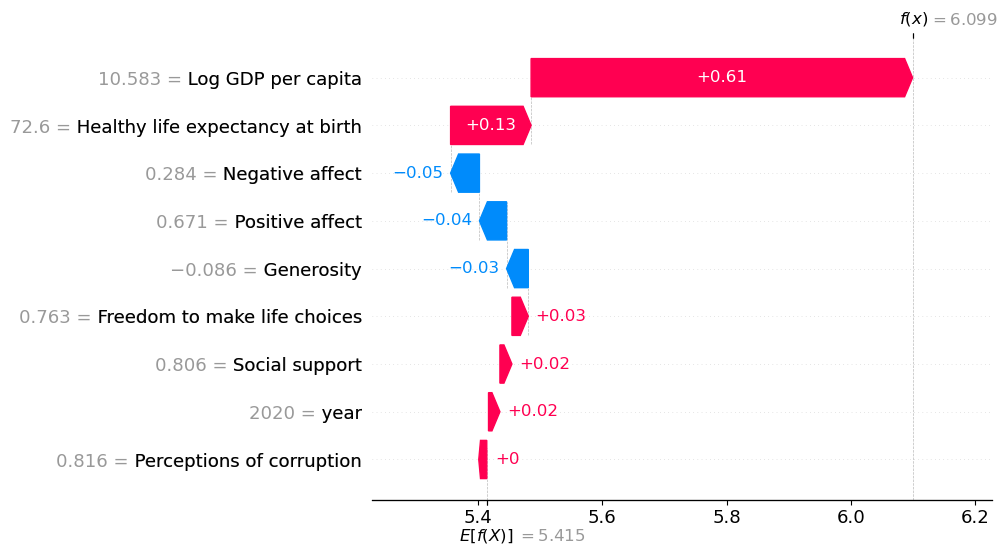

In [65]:
import shap
#Summarize the SHAP values for a specific prediction 
shap.plots.waterfall(shap_values_lgbm[100])

### Waterfall LightGBM Regressor shows how each feature contributes to the prediction for one sample.

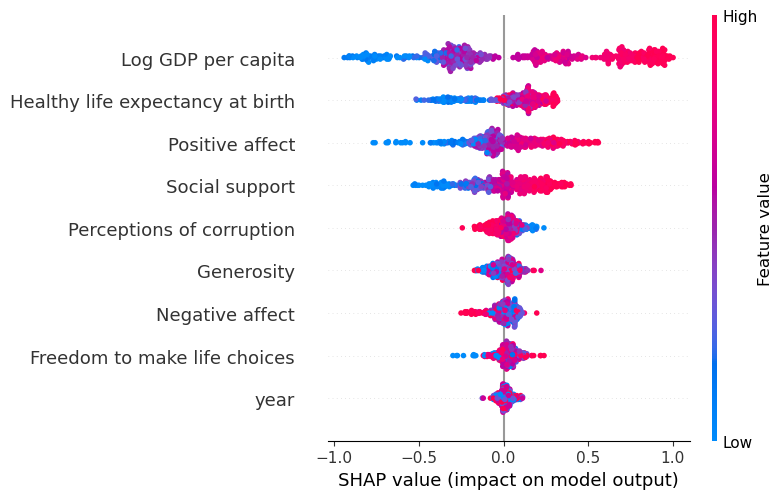

In [67]:
shap.summary_plot(shap_values_lgbm[:500], features_test[:500], show= False)


### Summary plot on LightGBM Regressor gives global overview of feature importance across many samples. This shows the whole dataset. 

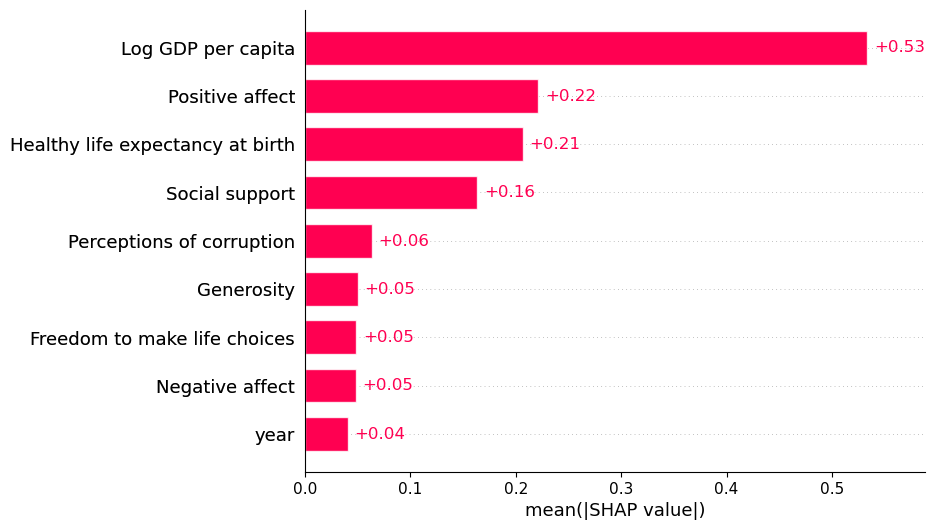

In [59]:
shap.plots.bar(shap_values_lgbm)

### Bar plot on LightGBM Regressor is showing the average absolute SHAP values for each features. Its helps to understand how each feature contributes to predictions on average.

In [66]:

model2 = CatBoostRegressor().fit(features_train, target_train)

explainer = shap.Explainer(model2, features_train)
shap_values_cbr = explainer(features_test, check_additivity=False)

Learning rate set to 0.044626
0:	learn: 1.0948076	total: 3.76ms	remaining: 3.76s
1:	learn: 1.0603695	total: 7.94ms	remaining: 3.96s
2:	learn: 1.0276068	total: 12ms	remaining: 3.98s
3:	learn: 0.9969302	total: 15.5ms	remaining: 3.86s
4:	learn: 0.9677158	total: 20ms	remaining: 3.98s
5:	learn: 0.9407344	total: 23.9ms	remaining: 3.96s
6:	learn: 0.9142003	total: 27.5ms	remaining: 3.91s
7:	learn: 0.8899628	total: 32.2ms	remaining: 3.99s
8:	learn: 0.8662062	total: 37ms	remaining: 4.08s
9:	learn: 0.8423363	total: 41ms	remaining: 4.05s
10:	learn: 0.8198180	total: 45.4ms	remaining: 4.08s
11:	learn: 0.8005310	total: 52.4ms	remaining: 4.32s
12:	learn: 0.7803021	total: 56.1ms	remaining: 4.26s
13:	learn: 0.7611693	total: 60.6ms	remaining: 4.27s
14:	learn: 0.7430790	total: 63.8ms	remaining: 4.19s
15:	learn: 0.7261684	total: 67.3ms	remaining: 4.14s
16:	learn: 0.7108020	total: 70.9ms	remaining: 4.1s
17:	learn: 0.6956628	total: 73.4ms	remaining: 4.01s
18:	learn: 0.6811953	total: 75.8ms	remaining: 3.91s
1

 99%|===================| 500/504 [00:23<00:00]        

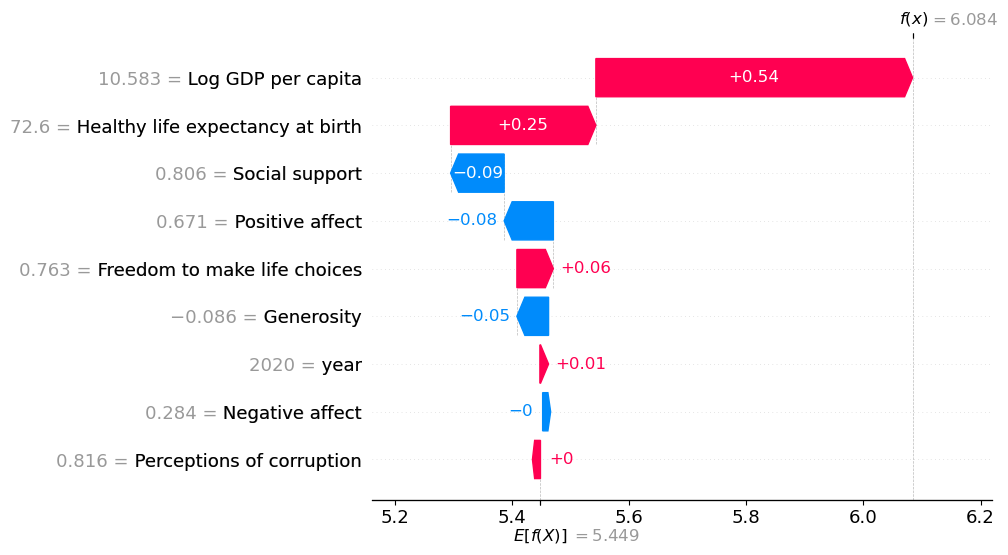

In [51]:
import shap
#Summarize the SHAP values for a specific prediction
shap.plots.waterfall(shap_values_cbr[100])

### Waterfall CatBoost Regressor shows how each feature contributes to the prediction for one sample.

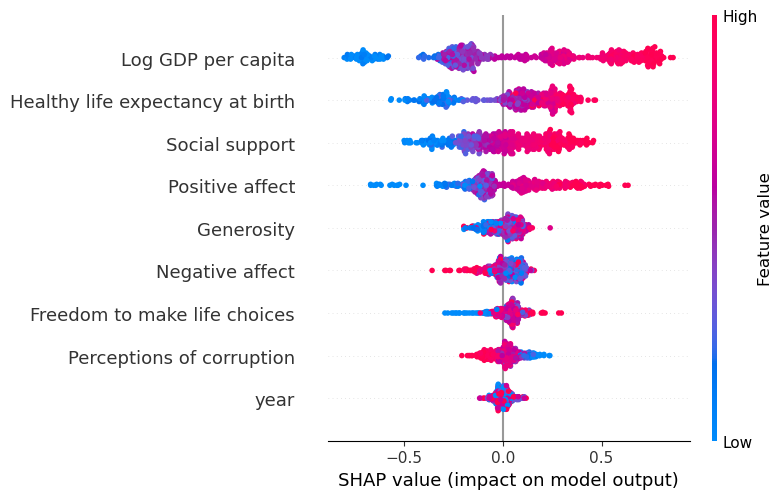

In [68]:
shap.summary_plot(shap_values_cbr[:500], features_test[:500], show= False)

### Summary plot on CatBoost Regressor gives global overview of feature importance across many samples. This shows the whole dataset. It can be seen that Log GDP per capita is most important according to our best model.

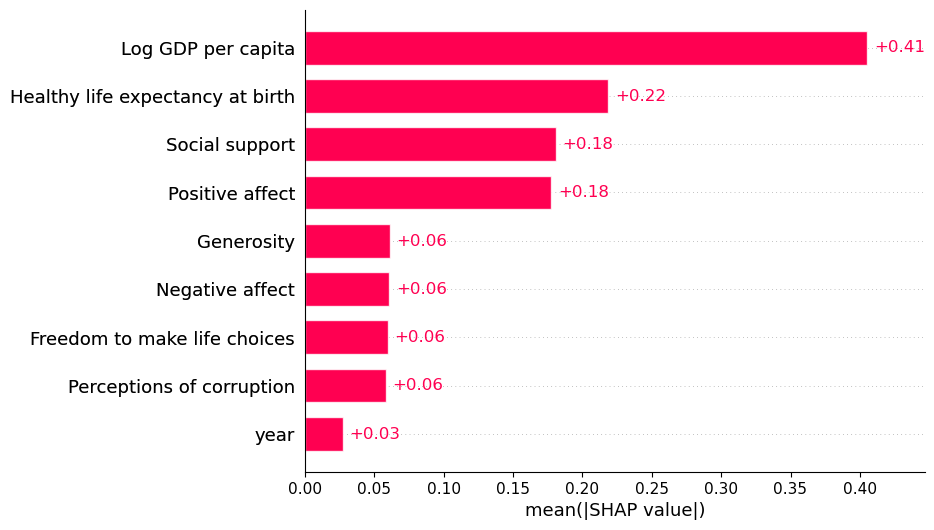

In [69]:
shap.plots.bar(shap_values_cbr)

 ### Bar plot on CatBoost Regressor is showing the average absolute SHAP values for each features. Its helps to understand how each feature contributes to predictions on average.